In [1]:
# install and restart run time 
#!pip install -U albumentations

### Clone from repository

In [2]:
!git clone "https://github.com/vvshankar78/DeepLearning.git"
import sys, os
my_path = 'DeepLearning/Extensive VisionAI-EVA6/08_Resnet'
sys.path.append(my_path)
# os.listdir(my_path)

fatal: destination path 'DeepLearning' already exists and is not an empty directory.


In [3]:
# # load Google Driver
# from google.colab import drive
# import sys, os
# drive.mount('/content/drive')


# my_path = '/content/drive/MyDrive/Computer Vision/Extensive VisionAI-EVA6/08_Resnet'
# sys.path.append(my_path)
# os.listdir(my_path)

In [4]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

In [6]:
# from model import Net2
from models import Resnet
from models import my_model
from train import train
from test1 import test
from config import ModelConfig
from utils import *
from data.data_engine import DataEngine

In [7]:
# View model config
args = ModelConfig()
args.dropout_value = 0.0
args.print_config()

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.0,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}


Files already downloaded and verified
Files already downloaded and verified


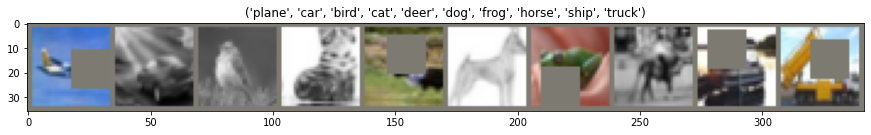

In [8]:
data = DataEngine(args)
data.show_samples()

In [9]:

train_loader = data.train_loader

test_loader = data.test_loader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#dict to store model loss and accuracy parameters
history = {}

CUDA Available? True


In [10]:
net = Resnet.ResNet18().to(device)

In [11]:
# temp = my_model.Net2(args).to(device)
# summary(temp, 
#         (3, 32, 32),)

In [12]:
# Input parameters for the model
EPOCHS = 3
l1_decay=0.000
l2_decay=0.0
#norm_type = "BN"
#num_groups=2
#input_img_size=(1, 28, 28)


# Run model for first 20 epochs with high rate, and half it thereafter
# model = Net2(args).to(device)
model = net
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", optimizer.param_groups[0]['lr'])
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, criterion, classes, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = 'Resnet18'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


/home/lebeast/projects/DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=1.7809138298034668 Batch_id=781 Accuracy=42.24: 100%|██████████| 782/782 [00:26<00:00, 29.31it/s]

length of Average loss 782, length of Average accuracy 782

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0191, Accuracy: 5563/10000 (55.63%)

EPOCH: 2


Loss=0.9320636987686157 Batch_id=781 Accuracy=58.37: 100%|██████████| 782/782 [00:26<00:00, 29.45it/s]

length of Average loss 1564, length of Average accuracy 1564

learning rate 0.01



  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0138, Accuracy: 6928/10000 (69.28%)

EPOCH: 3


Loss=0.8769553899765015 Batch_id=781 Accuracy=65.37: 100%|██████████| 782/782 [00:26<00:00, 29.39it/s]


length of Average loss 2346, length of Average accuracy 2346

learning rate 0.01
Test set: Average loss: 0.0120, Accuracy: 7315/10000 (73.15%)



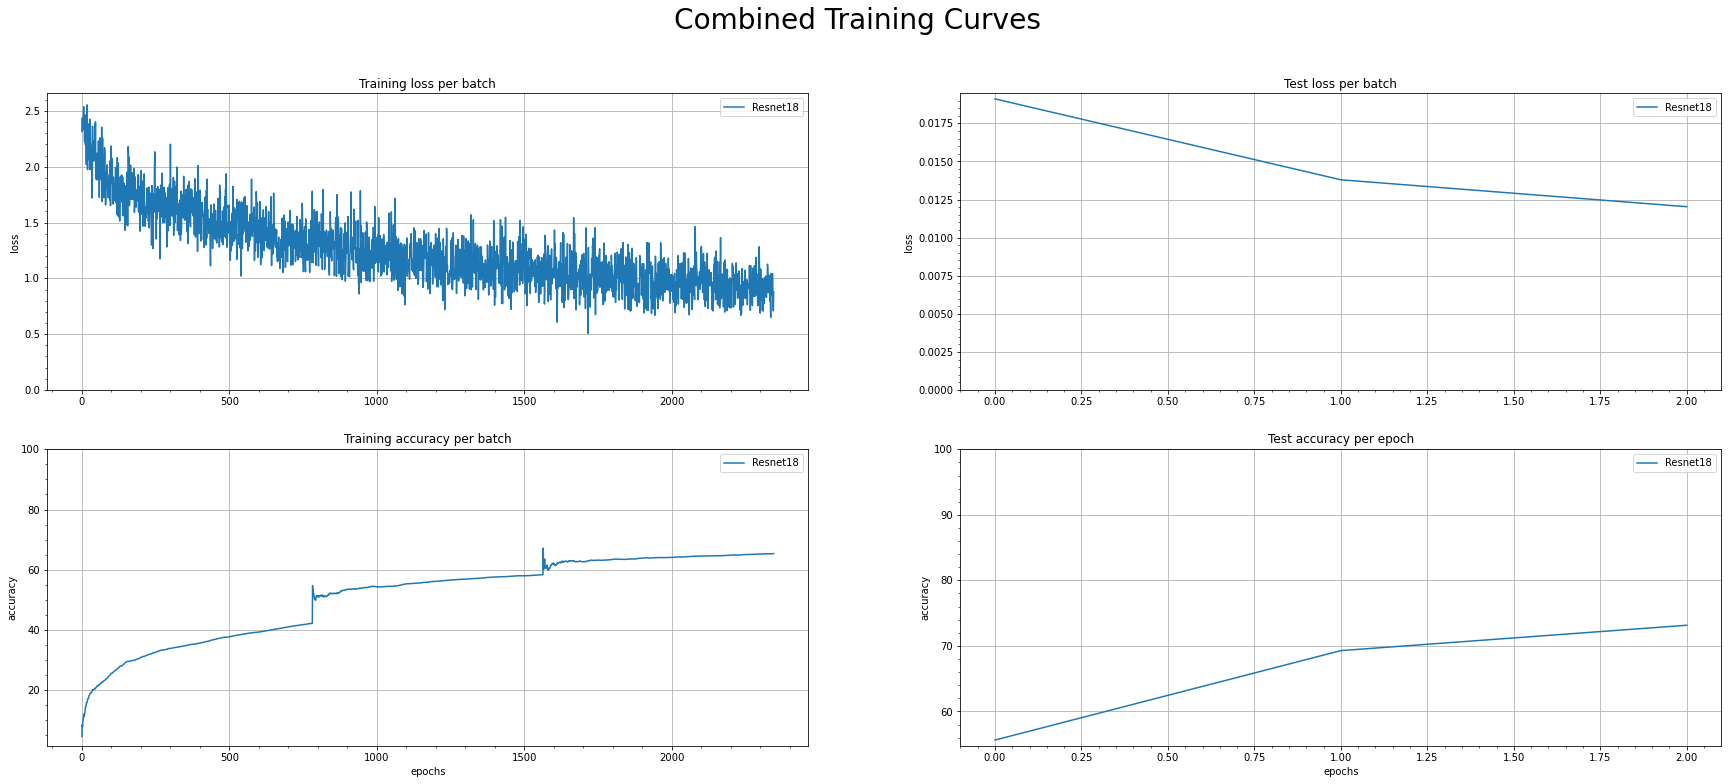

In [13]:
training_curves(history)

/home/lebeast/projects/DeepLearning/Extensive VisionAI-EVA6/08_Resnet/models/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


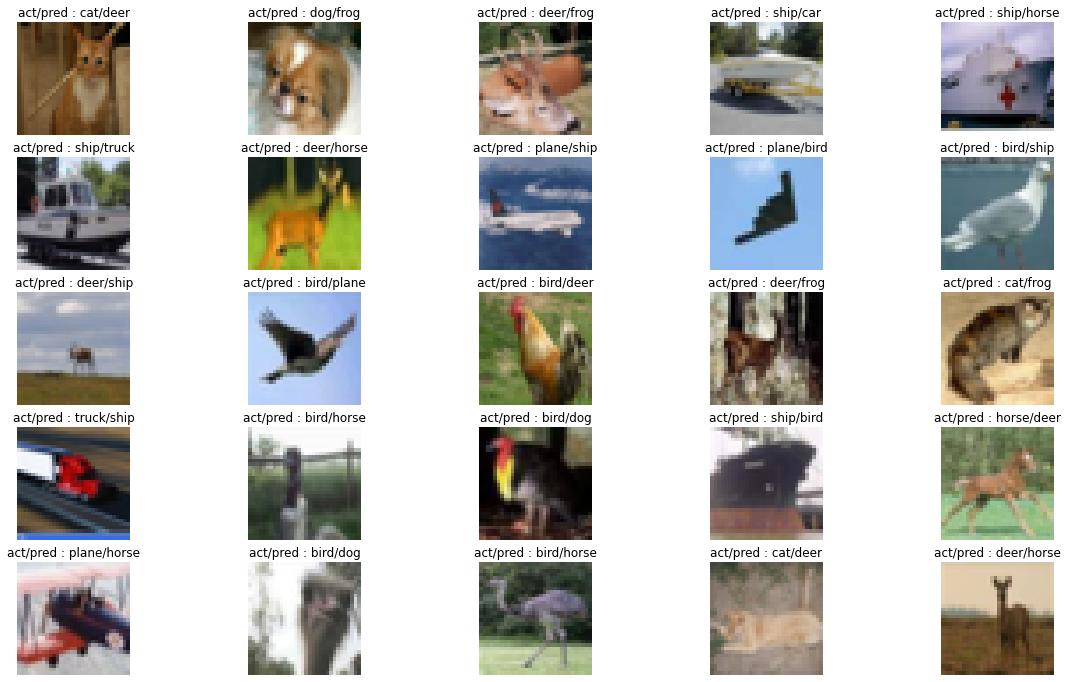

In [14]:
def imshow(img):
	img = denormalize(img)
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.grid(b=None)
	return img

#classes = data.classes

model.eval()

figure = plt.figure(figsize=(20, 12))
num_of_images = 25
index = 1

misclass_img_list = []
misclass_img_category = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                misclass_img_category.append(target[idx[0]].cpu().item())
                                  


                plt.title(titl)
                index += 1



In [15]:
mis_img_name_list = []

for i in range(len(misclass_img_list)):
  img_name = 'images/'+'mis_img'+str(i+1)+'.jpeg'
  mis_img_name_list.append(img_name)
  image = (255*torch.swapaxes(misclass_img_list[i], 0, 2))
  image = torch.swapaxes(image, 0, 1)
  image = image.type(torch.uint8).cpu().numpy()
  #print(image.shape)
  matplotlib.image.imsave(img_name, image)
  print(img_name)

images/mis_img1.jpeg
images/mis_img2.jpeg
images/mis_img3.jpeg
images/mis_img4.jpeg
images/mis_img5.jpeg
images/mis_img6.jpeg
images/mis_img7.jpeg
images/mis_img8.jpeg
images/mis_img9.jpeg
images/mis_img10.jpeg
images/mis_img11.jpeg
images/mis_img12.jpeg
images/mis_img13.jpeg
images/mis_img14.jpeg
images/mis_img15.jpeg
images/mis_img16.jpeg
images/mis_img17.jpeg
images/mis_img18.jpeg
images/mis_img19.jpeg
images/mis_img20.jpeg
images/mis_img21.jpeg
images/mis_img22.jpeg
images/mis_img23.jpeg
images/mis_img24.jpeg
images/mis_img25.jpeg


In [16]:
image = misclass_img_list[0]
print(image.shape)
image = torch.unsqueeze(image, 0)
print(image.shape)
#image = torch.swapaxes(image, 1, 2)
print(image.shape)
image = F.interpolate(image, size=224)
print(image[0].shape)

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([3, 224, 224])


In [17]:
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
                                         deprocess_image, \
                                         preprocess_image

### The Receptive Field of 7x7 is achieved in the middle of layer1, so we keep that as first

In [18]:
print(model.conv1, model.layer1)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
)


In [32]:
target_layer0 = model.layer1[0]    #RF 7x7
target_layer1 = model.layer1[-1]   #rest are the end of respective layers
target_layer2 = model.layer2[-1]
target_layer3 = model.layer3[-1]
target_layer4 = model.layer4[-1]

visualization = []   #store all the grad cam images here
rgb_img_list = []

missclassified_count = 3

for i in range(0, missclassified_count-1):
    
    image_path = 'images/mis_img' + str(i+1) + '.jpeg'
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    #rgb_img = cv2.resize(rgb_img, (224, 224))    #uncomment this to scale to 224x224
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    rgb_img_list.append(rgb_img)
    
    #we change it to correct category for each image
    #'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
    # 0,       1,     2,      3,     4,      5,     6,      7,       8,      9

    target_category = misclass_img_category[i]

    for layer in [target_layer0, target_layer1, target_layer2, target_layer3, target_layer4]:
        cam = GradCAM(model=model, target_layer=layer, use_cuda=cuda)
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        visualization.append(show_cam_on_image(rgb_img, grayscale_cam))


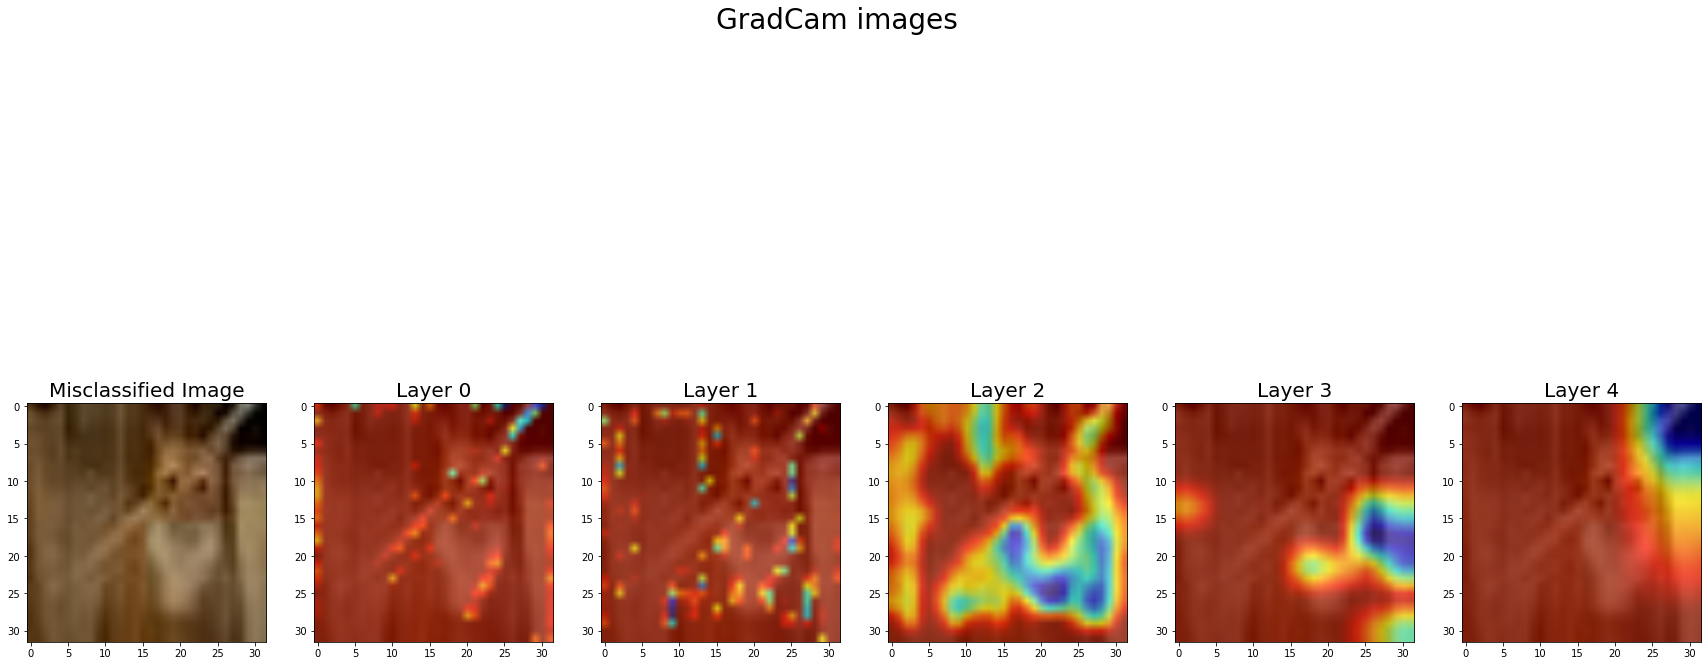

In [35]:
plt.rcParams['figure.figsize'] = [30, 15]
plt.figure(1)
plt.suptitle("GradCam images", fontsize=28)

plt.subplot(1, 6, 1)
plt.imshow(rgb_img_list[0], interpolation='bilinear')
plt.title("Misclassified Image", fontsize=20)

for i in range(0, 5):
    plt.subplot(1, 6, i+2)
    plt.imshow(visualization[i], interpolation='bilinear')
    title = 'Layer ' + str(i)
    plt.title(title, fontsize=20)
